# Loading the Packages

In [21]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import sys
import os
from keras.applications.vgg16 import VGG16
import keras
from numpy import load
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras import backend
from keras.layers import Dense
from keras.layers import Flatten
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D
from keras.optimizers import SGD
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

# Image Preprocessing

In [22]:
# import os
# import random
# import shutil

# def split_dataset(source_dir, dest_dir, train_split=0.7, valid_split=0.2, test_split=0.1):
#     assert abs(train_split + valid_split + test_split - 1.0) < 1e-6, "Splits must add up to 1"

#     classes = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

#     for split in ['train', 'valid', 'test']:
#         for class_name in classes:
#             os.makedirs(os.path.join(dest_dir, split, class_name), exist_ok=True)

#     for class_name in classes:
#         images = os.listdir(os.path.join(source_dir, class_name))
#         random.shuffle(images)

#         total = len(images)
#         train_end = int(total * train_split)
#         valid_end = train_end + int(total * valid_split)

#         for i, img in enumerate(images):
#             src_path = os.path.join(source_dir, class_name, img)

#             if i < train_end:
#                 dst_path = os.path.join(dest_dir, 'train', class_name, img)
#             elif i < valid_end:
#                 dst_path = os.path.join(dest_dir, 'valid', class_name, img)
#             else:
#                 dst_path = os.path.join(dest_dir, 'test', class_name, img)

#             shutil.copy(src_path, dst_path)

# source_dir = '/mnt/c/Users/PRAGYANSH/Downloads/PlantVillage'
# dest_dir = '/home/pragyansh/PlantVillage_split'

# split_dataset(source_dir, dest_dir)


In [23]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
traindir = os.path.expanduser("/home/pragyansh/PlantVillage_split/train")
validdir = os.path.expanduser("/home/pragyansh/PlantVillage_split/valid")
testdir = os.path.expanduser("/home/pragyansh/PlantVillage_split/test")

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 16
training_set = train_datagen.flow_from_directory(traindir,
                                                 target_size=(224, 224),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')

valid_set = valid_datagen.flow_from_directory(validdir,
                                            target_size=(224, 224),
                                            batch_size=batch_size,
                                            class_mode='categorical')


Found 14440 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


In [24]:
class_dict = training_set.class_indices
print(class_dict)

{'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1, 'Potato___Early_blight': 2, 'Potato___Late_blight': 3, 'Potato___healthy': 4, 'Tomato_Bacterial_spot': 5, 'Tomato_Early_blight': 6, 'Tomato_Late_blight': 7, 'Tomato_Leaf_Mold': 8, 'Tomato_Septoria_leaf_spot': 9, 'Tomato_Spider_mites_Two_spotted_spider_mite': 10, 'Tomato__Target_Spot': 11, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 12, 'Tomato__Tomato_mosaic_virus': 13, 'Tomato_healthy': 14}


In [25]:
li = list(class_dict.keys())
print(li)

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [26]:
train_num = training_set.samples
valid_num = valid_set.samples

In [27]:
from sklearn.utils import class_weight
import numpy as np

# After creating training_set
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(training_set.classes),
    y=training_set.classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

Class Weights: {0: np.float64(1.3811573409851745), 1: np.float64(0.9310122501611864), 2: np.float64(1.3752380952380951), 3: np.float64(1.3752380952380951), 4: np.float64(9.081761006289309), 5: np.float64(0.6469534050179212), 6: np.float64(1.3752380952380951), 7: np.float64(0.720558882235529), 8: np.float64(1.4454454454454455), 9: np.float64(0.77697067527576), 10: np.float64(0.8206876953680022), 11: np.float64(0.9803122878479293), 12: np.float64(0.4288047512991834), 13: np.float64(3.6883780332056193), 14: np.float64(0.8649296196466008)}


# Model Preparation

In [28]:
base_model=VGG16(include_top=False,input_shape=(224,224,3))
base_model.trainable=False

In [29]:
classifier=keras.models.Sequential()
classifier.add(base_model)
classifier.add(Flatten())
classifier.add(Dense(15,activation='softmax'))
classifier.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │       376,335 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,091,023 (57.57 MB)

 Trainable params: 376,335 (1.44 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [30]:
from tensorflow.keras.optimizers import Adam

for layer in base_model.layers[:-4]:  # Freeze all layers except the last 4
    layer.trainable = False
for layer in base_model.layers[-4:]:  # Unfreeze the last 4 layers
    layer.trainable = True

classifier.compile(
    optimizer=Adam(learning_rate=0.00001),  
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [31]:
#fitting images to CNN
from tensorflow.keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = classifier.fit(training_set,
                         steps_per_epoch=train_num//batch_size,
                         validation_data=valid_set,
                         epochs=20,
                         validation_steps=valid_num//batch_size,
                         callbacks=[earlystop],
                         class_weight=class_weights_dict
                         )
#saving model
#filepath="Mymodel.hdf5"
#model.save(filepath)

Epoch 1/20


/home/pragyansh/tf_projects/tf_env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


902/902 ━━━━━━━━━━━━━━━━━━━━ 83s 90ms/step - accuracy: 0.3776 - loss: 1.9829 - val_accuracy: 0.7507 - val_loss: 0.7584
Epoch 2/20
  1/902 ━━━━━━━━━━━━━━━━━━━━ 1:03 71ms/step - accuracy: 0.6250 - loss: 1.0137

/home/pragyansh/tf_projects/tf_env/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


902/902 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.6250 - loss: 1.0137 - val_accuracy: 0.7619 - val_loss: 0.7273
Epoch 3/20
902/902 ━━━━━━━━━━━━━━━━━━━━ 84s 93ms/step - accuracy: 0.7883 - loss: 0.6469 - val_accuracy: 0.8733 - val_loss: 0.3735
Epoch 4/20
902/902 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.6875 - loss: 0.7796 - val_accuracy: 0.8728 - val_loss: 0.3717
Epoch 5/20
902/902 ━━━━━━━━━━━━━━━━━━━━ 90s 99ms/step - accuracy: 0.8659 - loss: 0.4072 - val_accuracy: 0.8925 - val_loss: 0.3172
Epoch 6/20
902/902 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.8750 - loss: 0.7108 - val_accuracy: 0.9008 - val_loss: 0.3024
Epoch 7/20
902/902 ━━━━━━━━━━━━━━━━━━━━ 95s 106ms/step - accuracy: 0.8892 - loss: 0.3328 - val_accuracy: 0.8901 - val_loss: 0.3138
Epoch 8/20
902/902 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.9375 - loss: 0.1943 - val_accuracy: 0.8932 - val_loss: 0.3028
Epoch 9/20
902/902 ━━━━━━━━━━━━━━━━━━━━ 89s 99ms/step - accuracy: 0.9153 - loss: 0.2574 - val_accura

In [32]:
#Saving our model
filepath="Mymodel.h5"
classifier.save(filepath)

Visualizing the Accuracy

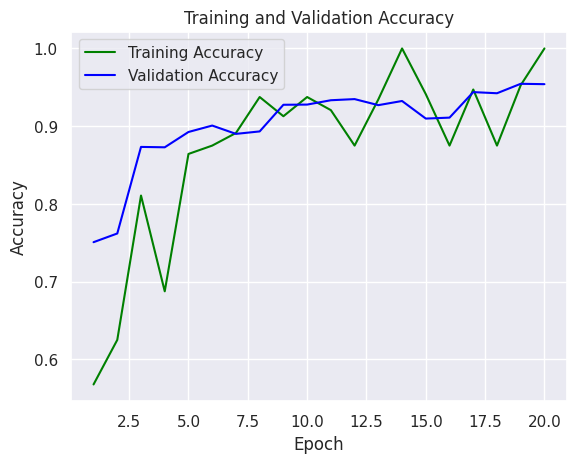

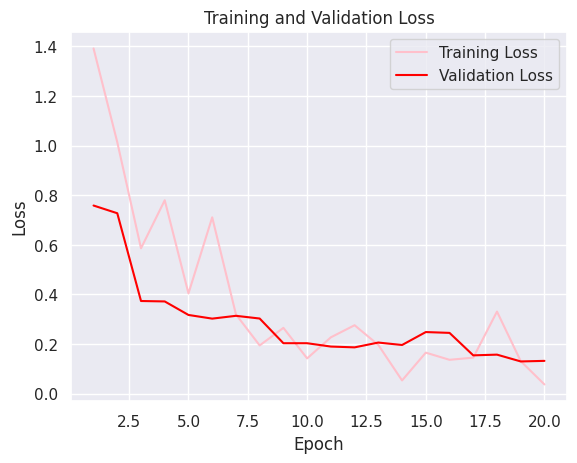

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Following is our prediction:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


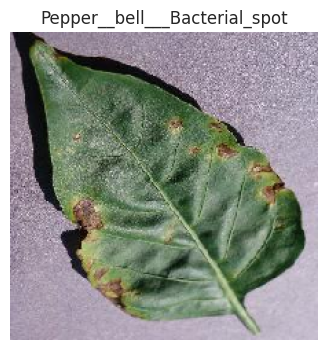

In [34]:
# predicting an image
from keras.preprocessing import image
import numpy as np
image_path = os.path.expanduser("~/tf_projects/models_testing/Plant-Disease-Detection-Using-VGG16/dataset/test/diseased/00f2e69a-1e56-412d-8a79-fdce794a17e4___JR_B.Spot 3132.JPG")
new_img = image.load_img(image_path, target_size=(224, 224))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255

print("Following is our prediction:")
prediction = classifier.predict(img)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
d = prediction.flatten()
j = d.max()
for index,item in enumerate(d):
    if item == j:
        class_name = li[index]

#ploting image with predicted class name        
plt.figure(figsize = (4,4))
plt.imshow(new_img)
plt.axis('off')
plt.title(class_name)
plt.show()

In [35]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    testdir,
    target_size=(224, 224),
    batch_size=1,  # Use batch size = 1 for individual predictions
    class_mode='categorical',
    shuffle=False
)


Found 2076 images belonging to 15 classes.


In [36]:
import numpy as np

# Get model predictions
predictions = classifier.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# True labels
y_true = test_generator.classes


2076/2076 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step


In [37]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='macro')   # <-- important
f1 = f1_score(y_true, y_pred, average='macro')            # <-- important

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9523121387283237
Recall: 0.9469278827692135
F1 Score: 0.9484100924657537


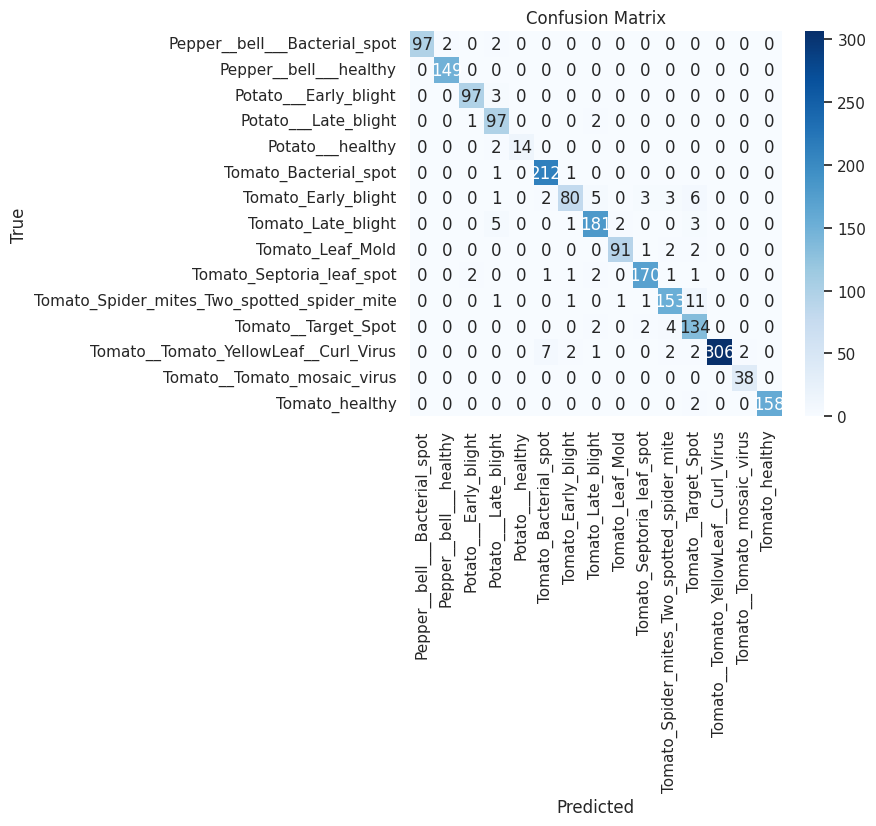

In [38]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=li, yticklabels=li, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()